In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from pyresample import image, geometry
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
uvel_centered = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr')
vvel_centered = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr')

uvel_centered = uvel_centered.isel(time=slice(41,378)).isel(k=0)

vvel_centered = vvel_centered.isel(time=slice(41,378)).isel(k=0)

uvel_centered['time'] = uvel_centered['time']/ np.timedelta64(1, 's')
vvel_centered['time'] = vvel_centered['time']/ np.timedelta64(1, 's')


In [49]:
256000*4

1024000

In [50]:

def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(i=ds_patch.i.size//2, j=ds_patch.j.size//2)
    center_lon, center_lat = center_point.x.values.item(), center_point.y.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 2160
    height = 2160

    # 512 x 512 km
    area_extent = (-1024000., -1024000., 1024000., 1024000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def image_to_dataset(im,variable_name):
    """Wrap pyresample image in xarray dataset."""
    geo_def = im.geo_def
    units = geo_def.proj_dict['units']
    lons, lats =  geo_def.get_lonlats()
    ds_resampled = xr.DataArray(im.image_data, dims=['y', 'x'],
                                coords={'x': ('x', geo_def.projection_x_coords, {'units':  units}),
                                        'y': ('y', geo_def.projection_y_coords, {'units':  units}),
                                        'lon': (['y', 'x'], lons),
                                        'lat': (['y', 'x'], lats)
                                       }, name=variable_name).to_dataset()
    ds_resampled.coords['projection'] = ('projection', [1], geo_def.proj_dict)
    
    # what metadata to save? this seems relevant
    # http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#grid-mappings-and-projections
    return ds_resampled

def resample_patch(ds_patch,variable_name):
    """Resample a patch of ocean."""
    grid_def = geometry.GridDefinition(lons=ds_patch.x.values, lats=ds_patch.y.values)
    data = ds_patch[variable_name].to_masked_array()
    im = image.ImageContainerBilinear(data, grid_def,
                                      radius_of_influence=4000., fill_value=None)
    
    area_def = target_area_def(ds_patch,variable_name)
    im_resampled = im.resample(area_def)
    return image_to_dataset(im_resampled,variable_name)

In [51]:
u_resampled = resample_patch(uvel_centered.isel(time=168),'U')

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/pyresample/bilinear/_numpy_resampler.py:91: FutureWarning: Usage of resample_bilinear() is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(


In [61]:
u_resampled.U#.plot()

<xarray.DataArray 'U' (y: 2160, x: 2160)>
array([[ 0.2260588 ,  0.21619747,  0.20672582, ..., -0.23473197,
        -0.19015228, -0.14635188],
       [ 0.21756777,  0.20907613,  0.19954101, ..., -0.28279261,
        -0.23882433, -0.19755649],
       [ 0.20792347,  0.19873314,  0.18913902, ..., -0.31414419,
        -0.27777376, -0.24024203],
       ...,
       [ 0.12963943,  0.10697773,  0.08650993, ...,  0.21831203,
         0.20917874,  0.2074858 ],
       [ 0.12454873,  0.10259003,  0.08515337, ...,  0.23052843,
         0.2248511 ,  0.22209086],
       [ 0.11811403,  0.09793816,  0.08198292, ...,  0.24418305,
         0.23545858,  0.23803611]])
Coordinates:
  * x        (x) float64 -1.024e+06 -1.023e+06 ... 1.023e+06 1.024e+06
  * y        (y) float64 1.024e+06 1.023e+06 1.022e+06 ... -1.023e+06 -1.024e+06
    lon      (y, x) float64 -4.029 -4.019 -4.009 -3.999 ... 21.91 21.93 21.94
    lat      (y, x) float64 -33.71 -33.71 -33.71 -33.71 ... -51.88 -51.88 -51.87

In [71]:
u_wavenumber = xrft.isotropic_power_spectrum(u_resampled.U.drop(['lon','lat']), dim=['x','y'],window=True)

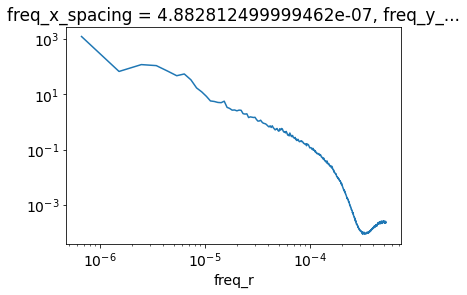

In [72]:
u_wavenumber.plot()
plt.xscale('log')
plt.yscale('log')